In [23]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [24]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease                          
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                                      
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease                                    
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease                                    
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease                        
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/sou

In [25]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [26]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [27]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [28]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile, clever_format
import random
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [29]:
# Text augmentation functions
def random_deletion_bn(text, p=0.05):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

def augment_bengali_text(text):
    # Randomly select one or two augmentations to avoid over-distortion
    augmentations = [
        lambda t: random_deletion_bn(t, p=0.05),
        lambda t: random_swap_bn(t, n=1),
        lambda t: char_noise_bn(t, p=0.03)
    ]
    selected = random.sample(augmentations, random.randint(1, 2))
    for aug in selected:
        text = aug(text)
    return text

In [30]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [31]:
df.head()

,id,caption,label
4677,4678,এ যেন এক সুগন্ধির মহাকাব্য!\nযার পঙক্তিমালায় র...,Non Informative
2042,2043,জন্মদিনে ১২ ফ্লেভারের ৩৬ ইঞ্চি পিৎজা পাবেন,Non Informative
410,411,মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন,Cyclone
4607,4608,"ফটিকছড়ি, বাংলাদেশের চট্টগ্রাম বিভাগ এর একটি উ...",Non Informative
1483,1484,ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...,Anthropogenic


In [32]:
# Define label mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [33]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [34]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [35]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [36]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms, is_train=False):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.is_train = is_train
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }
        self.index_to_class = {k.lower(): v for k, v in self.class_to_index.items()}
        self.missing_images = []

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        # Apply text augmentation for training
        if self.is_train:
            text = augment_bengali_text(text)

        # Load image with error handling
        image_path = None
        for ext in ['jpg', 'png', 'jpeg']:
            path = os.path.join(self.images_folder, f"{image_id}.{ext}")
            if os.path.exists(path):
                image_path = path
                break
        if not image_path:
            self.missing_images.append(image_id)
            # Return a dummy item to skip gracefully
            return self.__getitem__(random.randint(0, len(self)-1))

        try:
            image = Image.open(image_path).convert('RGB')
            image = self.image_transforms(image)
        except Exception as e:
            self.missing_images.append(image_id)
            return self.__getitem__(random.randint(0, len(self)-1))

        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 4, f"Label {label} out of range for ID {image_id}"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class.get(str(row.get('label_name', '')).lower(), 'unknown')
        }

In [37]:
images_folder = '/kaggle/input/mddb-images/Photos_Final'  # Updated to match dataset source
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [38]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1596
532
533


In [39]:
# Late Fusion Model
class LateFusionModel(nn.Module):
    def __init__(self, num_classes=5, roberta_model_name='xlm-roberta-base', efficientnet_model='efficientnet_b0'):
        super(LateFusionModel, self).__init__()
        
        # Text branch: XLM-RoBERTa
        self.roberta = XLMRobertaModel.from_pretrained(roberta_model_name)
        self.text_fc = nn.Sequential(
            nn.Linear(768, 256),  # Process RoBERTa [CLS] output
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Image branch: EfficientNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove original classifier
        self.image_fc = nn.Sequential(
            nn.Linear(in_features, 256),  # Process EfficientNet output
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final fusion and classification
        self.classifier = nn.Linear(256 + 256, num_classes)  # Concatenate processed text and image features
        
    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # [CLS] token embedding (768-dim)
        text_processed = self.text_fc(text_features)  # Process to 256-dim
        
        # Image features
        image_features = self.efficientnet(image)  # Extract image features
        image_processed = self.image_fc(image_features)  # Process to 256-dim
        
        # Late fusion: Concatenate processed features
        combined_features = torch.cat((text_processed, image_processed), dim=1)
        output = self.classifier(combined_features)
        
        return output


In [40]:
# Initialize model, loss, optimizer, scaler, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LateFusionModel(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scaler = GradScaler()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Training loop with early stopping
num_epochs = 10
train_losses = []
valid_losses = []
valid_accuracies = []
valid_f1s = []
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)
            _, preds = torch.max(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy_score(true_labels, pred_labels)
    valid_f1 = f1_score(true_labels, pred_labels, average='weighted')
    valid_accuracies.append(valid_accuracy)
    valid_f1s.append(valid_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}, "
          f"Val Acc: {valid_accuracy:.4f}, Val F1: {valid_f1:.4f}")

    # Update scheduler
    scheduler.step(valid_loss)

    # Save best model and check early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load best model for evaluation
model.load_state_dict(torch.save(best_model_path))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-40-4e6bb8cc3b5b>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.aut

Epoch 1/10, Train Loss: 1.5294, Val Loss: 1.3219, Val Acc: 0.5414, Val F1: 0.4389


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/10: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Train Loss: 0.9760, Val Loss: 0.6313, Val Acc: 0.8553, Val F1: 0.8530


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/10: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Train Loss: 0.5331, Val Loss: 0.4641, Val Acc: 0.8872, Val F1: 0.8855


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/10: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Train Loss: 0.3444, Val Loss: 0.3704, Val Acc: 0.8835, Val F1: 0.8820


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/10: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Train Loss: 0.2558, Val Loss: 0.2912, Val Acc: 0.9173, Val F1: 0.9173


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/10: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Train Loss: 0.1760, Val Loss: 0.3831, Val Acc: 0.9154, Val F1: 0.9148


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/10: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Train Loss: 0.1586, Val Loss: 0.3241, Val Acc: 0.9211, Val F1: 0.9210


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-4e6bb8cc3b5b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/10: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]
<ipython-input-40-4e6bb8cc3b5b>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Train Loss: 0.0906, Val Loss: 0.3178, Val Acc: 0.9305, Val F1: 0.9303
Early stopping triggered after 8 epochs.


TypeError: save() missing 1 required positional argument: 'f'


Test Set Evaluation:
Accuracy: 0.9212
Precision: 0.9232
Recall: 0.9212
F1 Score: 0.9211

Classification Report:
               precision    recall  f1-score   support

        flood       0.92      0.83      0.87       105
      cyclone       0.85      0.95      0.90       101
   earthquake       0.97      0.92      0.95       118
river erosion       0.90      0.92      0.91        86
anthropogenic       0.96      0.98      0.97       123

     accuracy                           0.92       533
    macro avg       0.92      0.92      0.92       533
 weighted avg       0.92      0.92      0.92       533



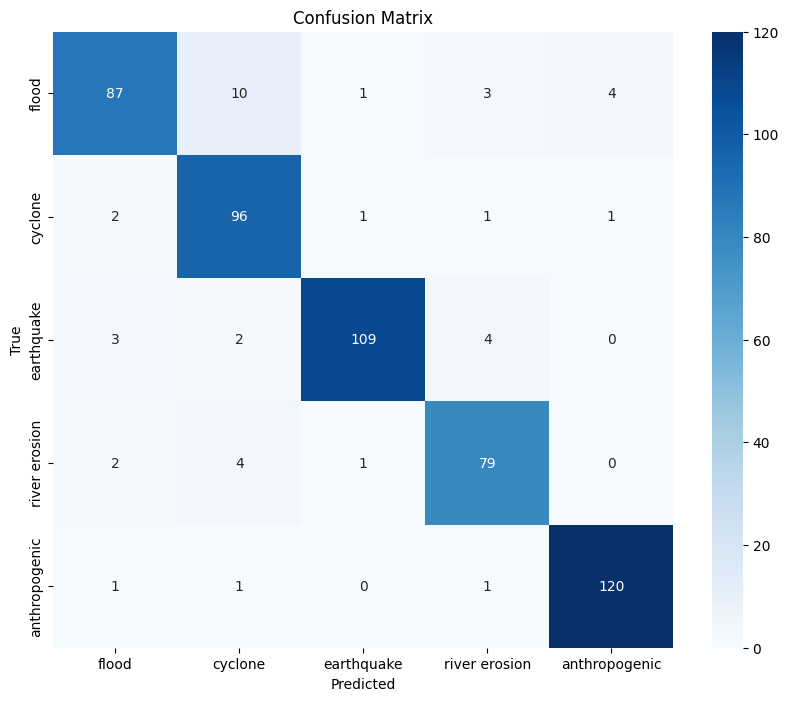

In [41]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

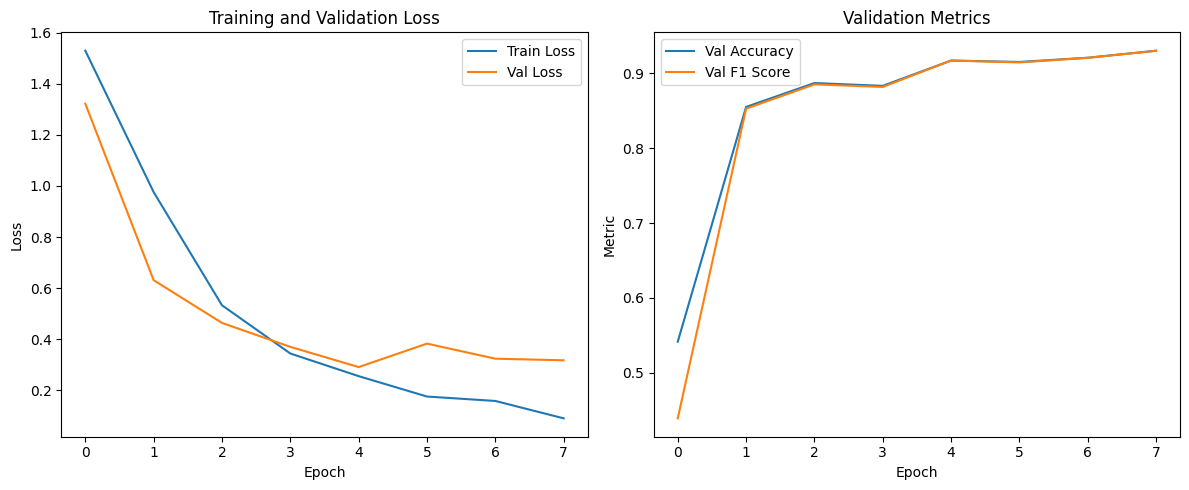

In [42]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Val Accuracy')
plt.plot(valid_f1s, label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# Profile the model
try:
    dummy_input_ids = torch.randint(0, tokenizer.vocab_size, (1, 128)).to(device)
    dummy_attention_mask = torch.ones(1, 128).to(device)
    dummy_image = torch.randn(1, 3, 224, 224).to(device)
    flops, params = profile(model, inputs=(dummy_input_ids, dummy_attention_mask, dummy_image), verbose=False)
    flops, params = clever_format([flops, params], "%.3f")
    print(f"\nModel Statistics:")
    print(f"Total Parameters: {params}")
    print(f"Total FLOPs: {flops}")
except Exception as e:
    print(f"\nProfiling failed: {str(e)}")
    params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {params / 1e6:.2f}M (approximate)")
    print("FLOPs: Not calculated")


Model Statistics:
Total Parameters: 90.182M
Total FLOPs: 11.296G
